In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import script
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 
plt.rcParams.update({'font.size': 20})

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = script.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

## harris et. al setup with selection

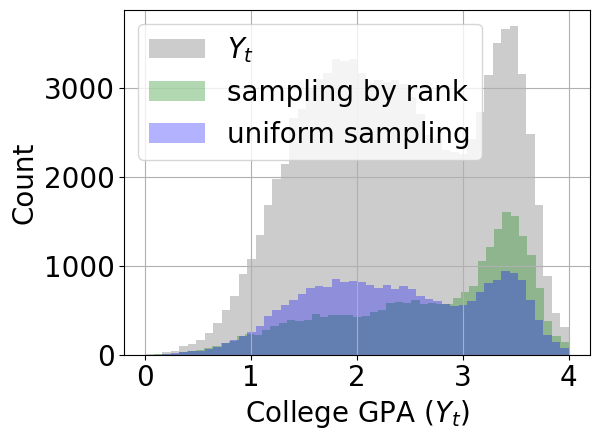

In [4]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type uniform'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

# df0 = pd.DataFrame(
    # {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     # 'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
# )
# df1 = pd.DataFrame(
    # {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
# )
# df0['class'] = 'disadv'
# df1['class'] = 'adv'
# df = pd.concat((df0, df1))
# df
# dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
# fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
# sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
# sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
# fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
# sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
# sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# fig,ax=plt.subplots()
# plt.hist(y[0],  histtype='step', bins=50)
# plt.hist(y[0][z==1], color='g', bins=50, alpha=.3)
# plt.hist(y[0][z==0], color='r', bins=50, alpha=.3)

cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type prediction'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y2,EW,theta, w, z2, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )
fig,ax=plt.subplots()
plt.hist(y2[0], alpha=.2 , color='k', bins=50, label=r'$Y_t$')
plt.hist(y2[0][z2==1], color='g', bins=50, alpha=.3, label='sampling by rank')
plt.hist(y[0][z==1], color='b', bins=50, alpha=.3, label='uniform sampling')
ax.grid()
ax.set_xlabel('College GPA ($Y_t$)')
ax.set_ylabel('Count')
ax.legend () 

assert np.all (y2[0] ==y[0] )
plt.tight_layout()
plt.savefig('figures/haris-et-al-selection-dist.pdf')

In [3]:
# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# dfa['status'] = f'accept $(W_t = 1)$'
# dfr['status'] = f'reject $(W_t = 0)$'
# df = pd.concat((dfa, dfr))
# fig,ax=plt.subplots()
# sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack', hue_order=(f'reject $(W_t = 0)$', f'accept $(W_t = 1)$'))
# ax.set_xlabel(r'College GPA $(Y_t)$')
# ax.set_ylabel('count')
# ax.grid()
# plt.tight_layout()
# plt.savefig('figures/harris-et-al-selection-setup.pdf')
# # sns.histplot(df, x='y', ax=ax)

In [5]:
n_runs = 50  
# ranking selection
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type prediction'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
runs = [r[0] for r in runs]

# uniform sampling
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type uniform'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs2 = p.starmap(script.run_multi_env, args_list )
runs2 = [r[0] for r in runs2]

99it [00:00, 136.83it/s]
47it [00:00, 163.91it/s]
99it [00:00, 141.40it/s]
99it [00:00, 118.80it/s]
99it [00:00, 121.62it/s]
0it [00:00, ?it/s]2it/s]
69it [00:00, 120.13it/s]
71it [00:00, 98.06it/s]]
73it [00:00, 138.82it/s]
89it [00:00, 154.90it/s]
99it [00:00, 114.17it/s]
63it [00:00, 146.05it/s]
99it [00:00, 138.06it/s]
99it [00:00, 134.21it/s]
99it [00:00, 166.93it/s]
99it [00:00, 135.90it/s]
99it [00:00, 135.09it/s]
99it [00:00, 121.35it/s]
99it [00:00, 149.21it/s]
99it [00:00, 124.54it/s]
99it [00:00, 120.02it/s]
86it [00:00, 123.14it/s]
99it [00:00, 148.66it/s]
99it [00:00, 159.50it/s]
99it [00:00, 128.36it/s]
99it [00:00, 110.56it/s]

99it [00:00, 137.43it/s]
99it [00:00, 131.70it/s]
99it [00:00, 125.36it/s]

99it [00:00, 161.39it/s]
99it [00:00, 111.27it/s]
68it [00:00, 171.93it/s]
99it [00:00, 165.17it/s]
99it [00:00, 128.14it/s]
79it [00:00, 201.72it/s]
99it [00:00, 152.89it/s]
99it [00:00, 144.91it/s]
99it [00:00, 215.11it/s]
99it [00:00, 161.23it/s]
99it [00:00, 140.88it/s

In [6]:
df = script.runs2df(runs)
df['sampling'] = 'rank'
df2 = script.runs2df(runs2)
df2['sampling'] = 'uniform'
df = pd.concat((df, df2 ))

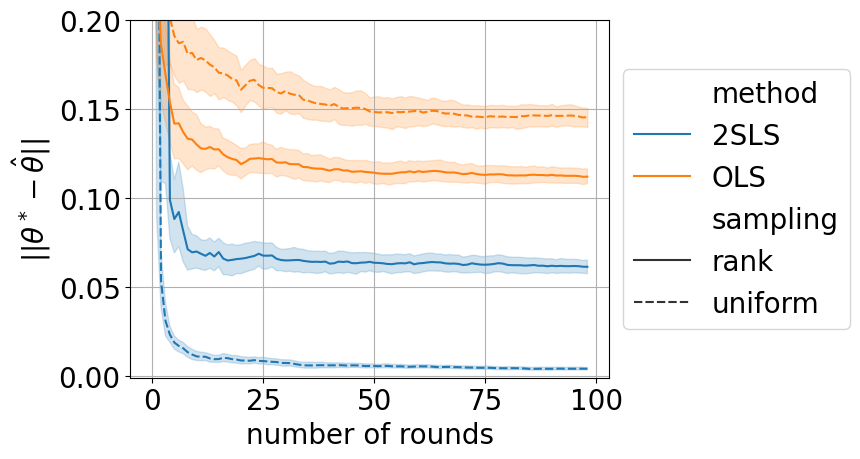

In [7]:
# converting to long format.
# df = script.runs2df(runs)
dflong = pd.melt(df, id_vars=('iterations', 'sampling'), value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

# plot
fig,ax=plt.subplots(figsize=(9,5))
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='sampling', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.legend(loc='upper right')
ax.set_ylabel(r'$||\theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('figures/harris-et-al-selection-results.pdf')

In [7]:
save_runs('experiments', 'harris-with-selection', (runs, runs2), args)
# with open('/home/maadil/strategic-iv/experiments/38f2b2def647847bd85caa97013d0f522014871e/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# with open('/home/maadil/strategic-iv/experiments/f711f06/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# runs 

## our setup.

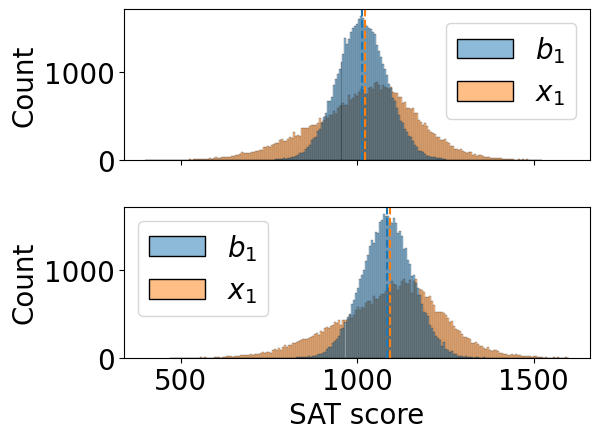

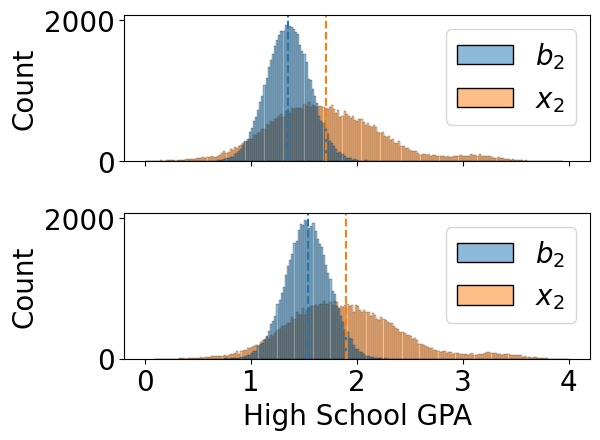

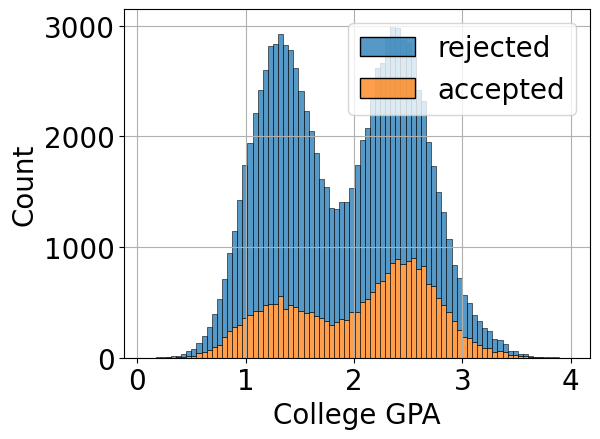

In [9]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .25'

args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {r'$b_1$': b[disadv_idx,0], r'$b_2$': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     r'$x_1$': x[disadv_idx,0], r'$x_2$': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {r'$b_1$': b[adv_idx,0], r'$b_2$': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], r'$x_1$': x[adv_idx, 0], r'$x_2$': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df.status.astype('category').cat.rename_categories({0.0:'rejected', 1.0: 'accepted'})
df['status']

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_1$', r'$x_1$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('SAT score')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0],  linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1],  linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data1.pdf')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_2$', r'$x_2$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('High School GPA')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data2.pdf')

# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
g = sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack')
g.legend_.set_title(None)
ax.set_xlabel('College GPA')
ax.grid()

plt.tight_layout()
plt.savefig('figures/our-settings-data3.pdf')

In [10]:
n_runs =50 
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
    _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

99it [00:06, 14.34it/s] 
99it [00:07, 14.02it/s]
99it [00:06, 14.37it/s]
99it [00:07, 13.50it/s]
99it [00:07, 13.99it/s]
99it [00:07, 12.70it/s]
99it [00:07, 12.86it/s]
99it [00:07, 13.74it/s]
99it [00:07, 13.00it/s]
99it [00:07, 12.50it/s]
99it [00:07, 13.26it/s]
98it [00:08,  5.71it/s]
99it [00:08, 12.30it/s]
99it [00:07, 13.08it/s]
99it [00:07, 12.73it/s]
99it [00:07, 12.95it/s]
98it [00:07,  5.91it/s]
99it [00:08, 12.07it/s]
99it [00:07, 13.56it/s]
99it [00:07, 12.41it/s]
99it [00:07, 13.01it/s]
99it [00:08, 12.26it/s]
99it [00:07, 12.61it/s]
99it [00:07, 12.86it/s]
99it [00:07, 13.81it/s]
99it [00:07, 12.90it/s]
99it [00:07, 13.01it/s]
99it [00:08, 12.29it/s]
99it [00:07, 13.19it/s]
99it [00:08, 11.96it/s]
99it [00:08, 11.99it/s]
99it [00:08, 12.32it/s]
99it [00:08, 11.68it/s]
99it [00:07, 13.18it/s]
99it [00:07, 12.85it/s]
99it [00:08, 11.46it/s]
99it [00:08, 11.51it/s]
99it [00:08, 11.75it/s]
99it [00:08, 11.43it/s]
99it [00:08, 11.74it/s]
99it [00:08, 11.82it/s]
99it [00:07, 12

In [5]:
# with open('experiments/f711f06/our-settings/results', 'rb') as f:
  # runs = pickle.load(f)
# runs

In [11]:
df = script.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours_vseq': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 

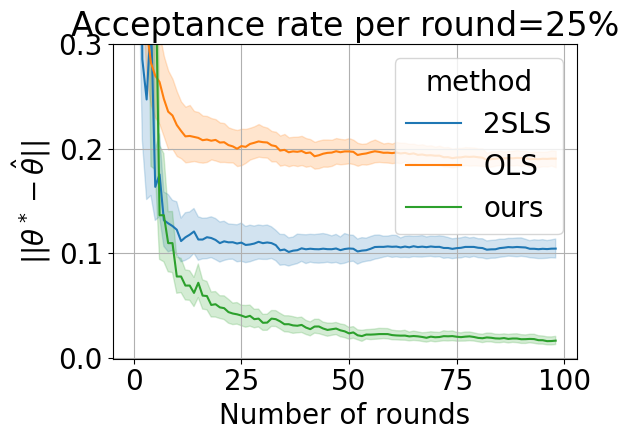

In [12]:
fig,ax=plt.subplots()
sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_ylim(bottom=-0.001, top=.3)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
ax.set_xlabel('Number of rounds')
ax.set_title('Acceptance rate per round=25%')

plt.tight_layout()
plt.savefig('figures/our-settings-single-env.pdf')

In [ ]:
save_runs('experiments', 'our-settings-single-env', runs, args)

In [13]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = script.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs_data = p.starmap(script.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = script.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  


1it [00:03,  3.23s/it]
1it [00:03,  3.18s/it]
1it [00:03,  3.18s/it]
1it [00:03,  3.22s/it]
1it [00:03,  3.24s/it]
1it [00:03,  3.21s/it]
1it [00:03,  3.23s/it]
1it [00:03,  3.25s/it]
1it [00:03,  3.22s/it]
1it [00:03,  3.35s/it]
1it [00:04,  4.45s/it]
1it [00:04,  4.37s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.46s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.44s/it]
1it [00:04,  4.43s/it]
1it [00:04,  4.47s/it]
1it [00:04,  4.33s/it]
1it [00:04,  4.45s/it]
1it [00:05,  5.65s/it]
1it [00:05,  5.58s/it]
1it [00:05,  5.65s/it]
1it [00:05,  5.69s/it]
1it [00:05,  5.73s/it]
1it [00:05,  5.63s/it]
1it [00:05,  5.59s/it]
1it [00:05,  5.55s/it]
1it [00:05,  5.58s/it]
1it [00:05,  5.54s/it]
1it [00:06,  6.88s/it]
1it [00:06,  6.91s/it]
1it [00:06,  6.98s/it]
1it [00:06,  6.84s/it]
1it [00:06,  6.72s/it]
1it [00:06,  6.72s/it]
1it [00:06,  6.80s/it]
1it [00:06,  6.94s/it]
1it [00:06,  6.78s/it]
1it [00:06,  6.81s/it]
1it [00:07,  7.94s/it]
1it [00:07,  7.95s/it]
1it [00:07,  7.98s/it]
1it [00:07,

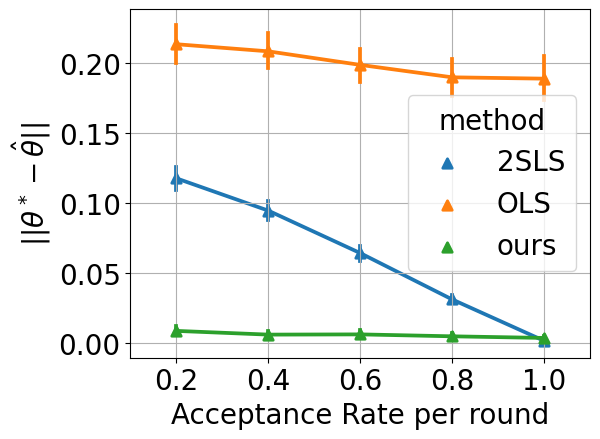

In [14]:
dflong
fig,ax=plt.subplots() 
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours_vseq': 'Ours'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax.grid() 

ax.set_xlabel('Acceptance Rate per round')
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
plt.tight_layout()
plt.savefig('figures/our-setttings-single-env-ablation.pdf')

In [18]:
save_runs('experiments', 'our-settings-single-env-ablation', dflong, args)

## multiple envs clone.

In [16]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2 --envs-accept-rate .25 .25'
args = script.get_args(cmd)

In [21]:
n_runs = 50
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
runs = [r[0] for r in runs]

99it [00:01, 52.19it/s] 
99it [00:01, 49.50it/s]]
99it [00:01, 61.98it/s] 
0it [00:00, ?it/s]
24it [00:00, 239.92it/s]
99it [00:01, 62.80it/s]]
51it [00:00, 62.50it/s] 
35it [00:00, 56.09it/s]]
99it [00:01, 62.44it/s]]
71it [00:01, 34.55it/s]
75it [00:01, 33.37it/s] 
2it [00:00, 19.49it/s]]]
51it [00:00, 72.84it/s]
3it [00:00, 29.30it/s]]]
59it [00:01, 41.80it/s]

80it [00:01, 34.82it/s]]
65it [00:01, 44.26it/s]
99it [00:01, 53.77it/s]]
0it [00:00, ?it/s]t/s]]]
99it [00:01, 62.16it/s]]
78it [00:01, 41.47it/s]]
44it [00:00, 102.69it/s]
35it [00:00, 102.45it/s]
31it [00:00, 69.13it/s]
62it [00:01, 51.33it/s]
20it [00:00, 81.25it/s]]
76it [00:00, 75.07it/s]]
99it [00:02, 48.53it/s]]
64it [00:00, 69.07it/s]]
64it [00:01, 65.20it/s]
66it [00:01, 52.04it/s] 
65it [00:01, 58.20it/s]]
99it [00:02, 49.22it/s]]
72it [00:01, 50.53it/s]]

0it [00:00, ?it/s]it/s]
91it [00:01, 41.59it/s]]
0it [00:00, ?it/s]it/s]
79it [00:01, 59.05it/s]
77it [00:00, 86.79it/s] 
94it [00:02, 40.22it/s]
99it [00:01, 77

In [22]:
# save_runs('experiments', 'multi-env-clone', runs, args)
# with open('experiments/f711f06/multi-env-clone/results', 'rb') as f:
  # runs = pickle.load(f)

In [23]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,NaN,2sls
1,1,env0,0.744520,2sls
2,2,env0,0.037772,2sls
3,3,env0,0.039014,2sls
4,4,env0,0.022935,2sls
...,...,...,...,...
29695,94,env1,0.037037,ours_vseq
29696,95,env1,0.037037,ours_vseq
29697,96,env1,0.038445,ours_vseq
29698,97,env1,0.038445,ours_vseq


Text(0.5, 0, 'number of rounds')

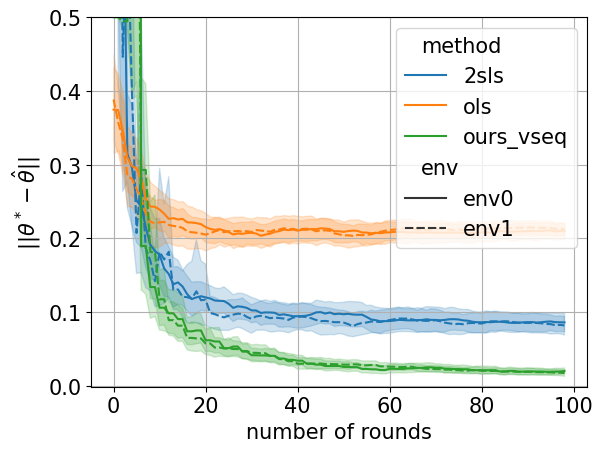

In [24]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## multi envs.

In [25]:
# acceptance rate experiments.
a1 = (.1, .25, .5, .75, .9)
a2 = (.1, .25, .5, .75, .9)
dfs = []
for _a1 in a1:
    for _a2 in a2:

        cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2 --envs-accept-rate {_a1} {_a2} --theta-star-std 0.1 --offline-eval' # --envs-accept-rates .2 .6 1' # num accept rate 
        args = script.get_args(cmd)

        n_runs = 50  
        args_list = [(s, args) for s in np.arange(n_runs)]
        with Pool(n_runs) as p:
            runs = p.starmap(script.run_multi_env, args_list )
        runs = [r[0] for r in runs]

        df = script.runs2df(runs)
        df['a1'], df['a2'] = _a1, _a2
     
        dfs.append(df)

1it [00:00, 11.59it/s]
1it [00:00, 38.25it/s]
1it [00:00,  5.87it/s]
1it [00:00,  5.68it/s]
1it [00:00, 44.97it/s]
1it [00:00, 63.79it/s]
1it [00:00,  6.22it/s]
1it [00:00, 57.54it/s]
1it [00:00,  5.20it/s]
1it [00:00, 11.07it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  5.09it/s]
1it [00:00,  4.31it/s]
1it [00:00, 29.04it/s]
1it [00:00,  6.03it/s]
1it [00:00, 46.07it/s]
1it [00:00,  4.29it/s]
1it [00:00, 38.04it/s]

1it [00:00, 23.75it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  6.39it/s]

1it [00:00,  4.47it/s]

1it [00:00, 51.41it/s]
1it [00:00,  7.39it/s]
1it [00:00, 33.38it/s]


1it [00:00, 57.25it/s]

0it [00:00, ?it/s]t/s]
1it [00:00, 59.70it/s]
1it [00:00,  5.74it/s]

1it [00:00,  5.38it/s]

0it [00:00, ?it/s]t/s]
1it [00:00, 64.46it/s]
1it [00:00, 54.14it/s]

1it [00:00,  4.54it/s]

1it [00:00,  5.74it/s]
1it [00:00, 76.01it/s]


0it [00:00, ?it/s]t/s]
1it [00:00, 32.84it/s]

0it [00:00, ?it/s]t/s]
1it [00:00,  7.49it/s]
1it [00:00,  7.34it/s]
1it [00:00,  7.99it/s]

0it [00:00, ?it/s]t/

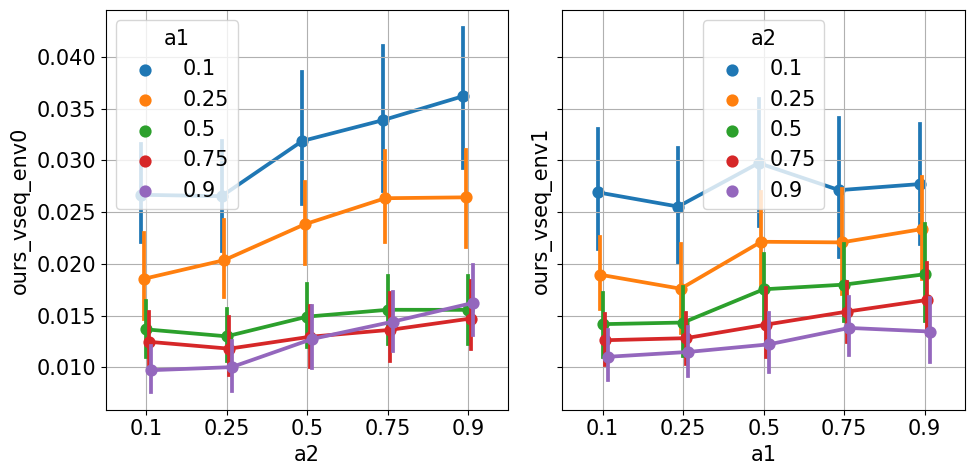

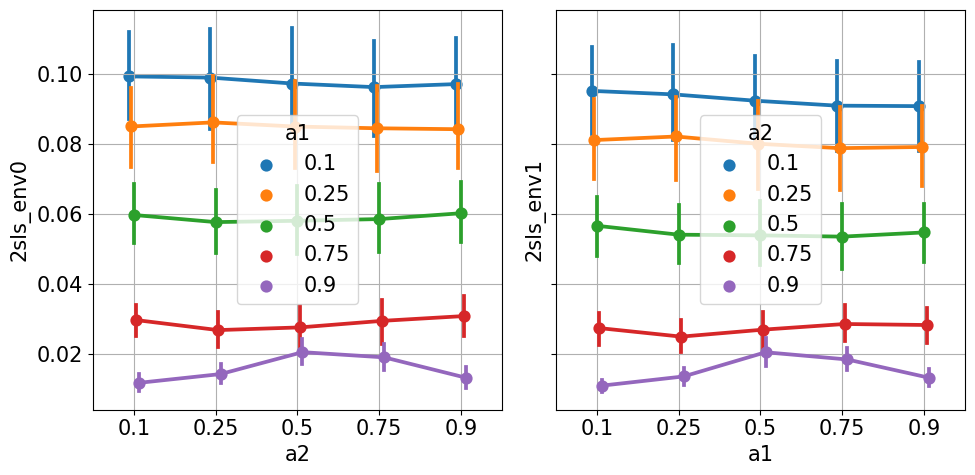

In [26]:
df = pd.concat(dfs)
fig, ax=plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
sns.pointplot(df, x='a2', y='ours_vseq_env0', hue='a1', dodge=True, ax=ax[0])
sns.pointplot(df, x='a1', y='ours_vseq_env1', hue='a2', dodge=True, ax=ax[1])
ax[0].grid()
ax[1].grid()
plt.tight_layout() 

fig, ax=plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.pointplot(df, x='a2', y='2sls_env0', hue='a1', dodge=True, ax=ax[0])
sns.pointplot(df, x='a1', y='2sls_env1', hue='a2', dodge=True, ax=ax[1])
ax[0].grid()
ax[1].grid()
plt.tight_layout () 
# sns.pointplot(df, x='a2', y='ours_vseq_env0', hue='a2')

In [27]:
# save_runs('experiments', 'selection-acceptance-rates', runs, args)

## multiple environments (theta exp.)

In [35]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 3 --envs-accept-rate .25 .25 .25 --theta-star-std 0 --theta-per-env'
args = script.get_args(cmd)
np.random.seed(2)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

In [36]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df


,b1,b2,status,y,y_hat,x1,x2,y_env0,y_env1,y_env2,w_env0,w_env1,w_env2,class
0,1067.769557,1.177815,2.0,1.332817,0.084388,1031.008372,1.872117,1.332817,1.268003,1.763233,0.0,1.0,0.0,disadv
1,928.647420,0.764346,0.0,1.856519,1.648174,1024.526863,2.486550,1.856519,1.776108,1.789633,0.0,0.0,0.0,disadv
2,921.635462,1.451358,2.0,1.445013,-0.460284,993.146325,2.117302,1.445013,1.780289,1.522159,0.0,1.0,0.0,disadv
3,963.364638,1.272386,0.0,1.083795,-0.109694,1006.745004,1.304372,1.083795,1.244792,1.361116,0.0,0.0,0.0,disadv
4,869.164072,1.528661,2.0,1.413531,-0.061723,885.634740,1.904152,1.413531,1.396740,1.207464,0.0,1.0,0.0,disadv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1079.794604,1.512832,3.0,1.996966,15.594219,1184.325455,1.313394,1.996966,2.096837,2.534689,1.0,0.0,1.0,adv
49996,835.139683,1.691467,3.0,2.958017,-1.590129,898.650810,2.459239,2.958017,2.520613,2.587422,0.0,0.0,1.0,adv
49997,1040.688768,0.820839,0.0,1.942712,-1.294456,965.288260,1.564756,1.942712,2.420574,2.103964,0.0,0.0,0.0,adv
49998,1002.011175,1.056677,0.0,2.505840,0.505847,1132.666932,1.889237,2.505840,2.436409,2.678954,0.0,0.0,0.0,adv


2.0151472641854418
2.1471302048320853
2.3043428981487004
2.3426852365321884


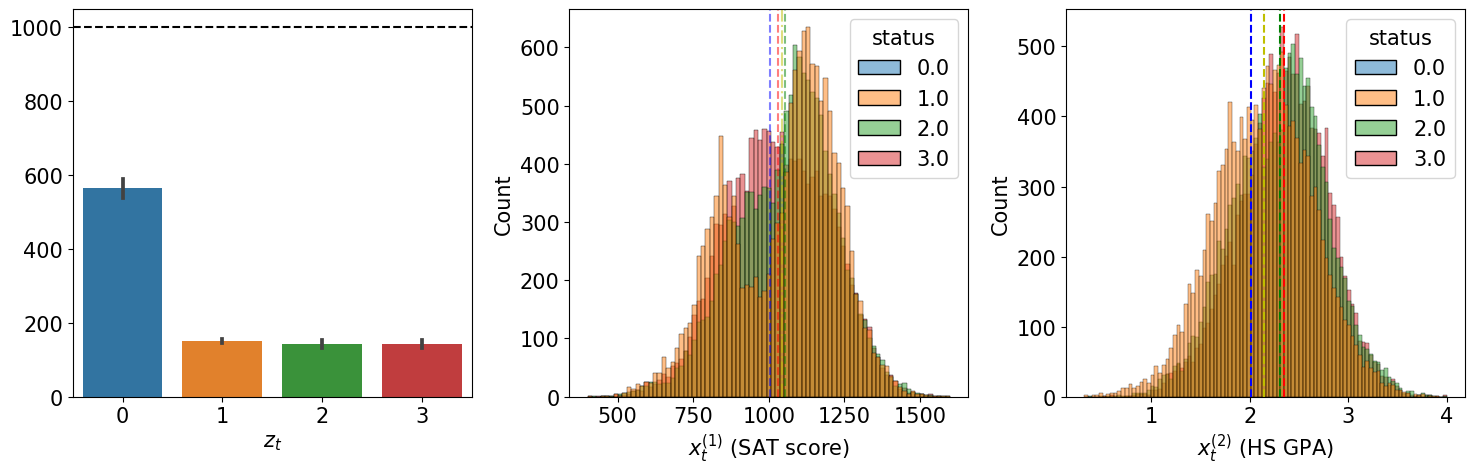

In [37]:

fig,ax=plt.subplots(ncols=3, figsize=(15, 5))

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax[0].axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax[0])
ax[0].set_xlabel(r'$z_t$')

# second plot
sns.histplot(df[df.status!=0], x='x1', hue='status', ax=ax[1])
ax[1].axvline(x=df[df.status==0].x1.mean(), color='b', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==1].x1.mean(), color='y', alpha=.5, linestyle='-.')
ax[1].axvline(x=df[df.status==2].x1.mean(), color='g', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==3].x1.mean(), color='r', alpha=.5, linestyle='--')
ax[1].set_xlabel(r'$x_t^{(1)}$ (SAT score)')

# third plot
sns.histplot(df[df.status!=0], x='x2', hue='status', ax=ax[2])
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df.status==env_idx].x2.mean())
  ax[2].axvline(x=df[df.status==env_idx].x2.mean(), c=c, linestyle='--')

# ax[2].axvline(x=df[df.status==3].x2.mean(), c='r', linestyle='-.', alpha=.5)
ax[2].set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 

In [38]:
for env_idx in range(args.num_envs):
    print(df[df[f'w_env{env_idx}']==1][['x1']].mean()) 
for env_idx in range(args.num_envs):
    print(df[df[f'w_env{env_idx}']==1][['x2']].mean()) 
for env_idx in range(args.num_envs+1):
    print(df[df.status==env_idx][['x1']].mean()) 
for env_idx in range(args.num_envs+1):
    print(df[df.status==env_idx][['x2']].mean()) 

x1    1070.924744
dtype: float64
x1    1077.605124
dtype: float64
x1    1063.276566
dtype: float64
x2    2.234162
dtype: float64
x2    2.339637
dtype: float64
x2    2.371824
dtype: float64
x1    1004.666987
dtype: float64
x1    1044.763029
dtype: float64
x1    1054.939051
dtype: float64
x1    1030.305926
dtype: float64
x2    2.015147
dtype: float64
x2    2.14713
dtype: float64
x2    2.304343
dtype: float64
x2    2.342685
dtype: float64


In [39]:
n_runs = 50  
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
    
runs = [r[0] for r in runs]

99it [00:01, 67.04it/s]]
99it [00:01, 66.62it/s] 
75it [00:01, 64.77it/s]]
99it [00:01, 73.91it/s]]
99it [00:01, 72.07it/s]]
99it [00:00, 106.11it/s]
99it [00:01, 66.64it/s]
85it [00:00, 75.29it/s]]

99it [00:01, 82.81it/s] 
0it [00:00, ?it/s]4it/s]
99it [00:01, 97.56it/s] 
16it [00:00, 85.24it/s] 
99it [00:01, 88.08it/s]]
77it [00:01, 55.90it/s] 
0it [00:00, ?it/s]it/s]]
99it [00:01, 74.91it/s]
23it [00:00, 222.38it/s]
99it [00:01, 80.35it/s] 
56it [00:00, 54.16it/s]]
99it [00:01, 60.12it/s]]
57it [00:01, 43.78it/s] 
0it [00:00, ?it/s]it/s]]
39it [00:00, 50.81it/s] 
69it [00:01, 34.16it/s]]
4it [00:00, 36.59it/s]]]
69it [00:00, 59.72it/s]
0it [00:00, ?it/s]it/s] 
67it [00:00, 82.74it/s] 
12it [00:00, 59.00it/s]]
87it [00:01, 53.54it/s] 
77it [00:01, 54.30it/s]]
78it [00:01, 56.84it/s]]
9it [00:00, 81.17it/s]]
31it [00:00, 87.30it/s] 
99it [00:02, 43.70it/s]
99it [00:01, 65.30it/s]]
65it [00:01, 47.01it/s]]
90it [00:01, 38.11it/s]]
17it [00:00, 167.55it/s]
99it [00:02, 36.74it/s]]
57it

Text(0.5, 0, 'number of rounds')

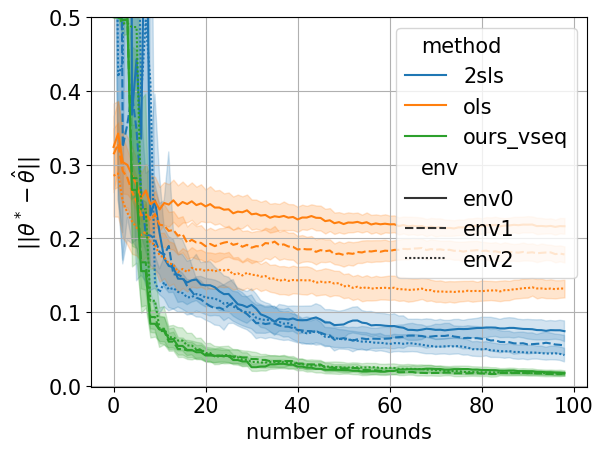

In [40]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## preference vector.

In [52]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d
    
n_envs = 3
# pref_vects = [[1] * n_envs, [r+1 for r in range(n_envs)]]
# for i, p in enumerate(pref_vects): 
  # p = [_p / sum(p) for _p in p]
  # pref_vects[i] = p
# print(pref_vects)

pref_vects = [
   np.ones(shape=(n_envs,)), np.array([1, 2, 4]) 
]
dfs = []
for pref_convex_comb in (0, 1):
    p = (1-pref_convex_comb)* pref_vects[0] + (pref_convex_comb) * pref_vects[1]
    print(p )
    p_string = ' '.join([str(_p) for _p in p])
    cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs {n_envs} --envs-accept-rate .25 .25 .25 --theta-star-std 0.1 --theta-per-env --pref-vect {p_string}'
    args = script.get_args(cmd)

    np.random.seed(1)
    b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
        args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
        )
    df = {'x1': x[:,0], 'x2': x[:, 1], 'b1': b[:, 0], 'b2': b[:, 1], 'z': z}
    df = add_envs(df, np.arange(args.num_applicants), y, 'y')
    df = pd.DataFrame(df )
    df['pref_convex_comb'] = pref_convex_comb
    dfs.append(df )
df = pd.concat(dfs)

[1. 1. 1.]
[1. 2. 4.]


In [53]:
df.groupby('pref_convex_comb').mean()

,x1,x2,b1,b2,z,y_env0,y_env1,y_env2
pref_convex_comb,,,,,,,,
0,1021.496151,2.122639,961.013754,1.201364,0.86076,1.973195,2.049029,1.608274
1,1036.565911,2.156983,979.794369,1.097998,0.94944,1.988935,2.066007,1.618110


<AxesSubplot:xlabel='x2', ylabel='Count'>

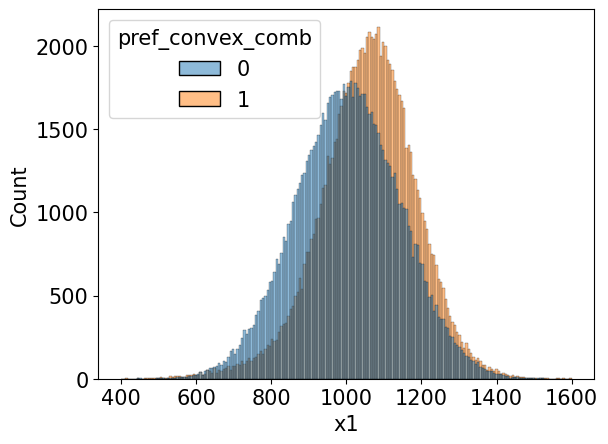

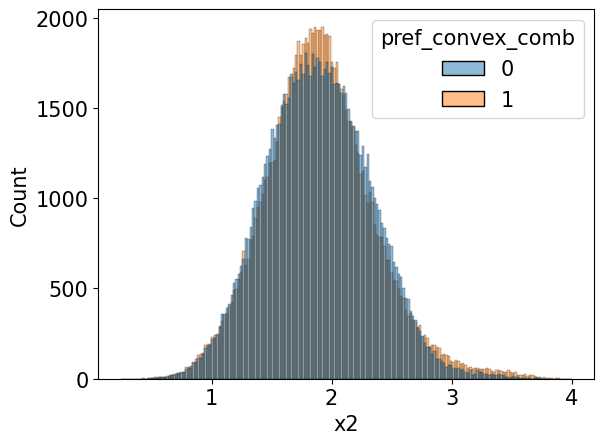

In [49]:
fig,ax=plt.subplots()
sns.histplot (data=df, x='x1', hue='pref_convex_comb')
fig,ax=plt.subplots()
sns.histplot (data=df, x='x2', hue='pref_convex_comb')

In [14]:


# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df


,b1,b2,status,y,y_hat,x1,x2,y_env0,y_env1,y_env2,w_env0,w_env1,w_env2,class
0,980.579825,0.848634,0.0,1.470167,-0.622721,828.973019,2.299472,1.470167,1.607543,1.580299,0.0,0.0,0.0,disadv
1,972.662947,0.962004,0.0,1.168388,0.760684,1150.959353,1.401815,1.168388,1.334189,1.128068,0.0,0.0,0.0,disadv
2,1024.595249,0.836989,0.0,1.243416,-0.092549,1001.332335,1.181481,1.243416,0.958307,1.345111,0.0,0.0,0.0,disadv
3,816.869626,1.047356,1.0,0.896709,1.637917,943.440537,1.575386,0.896709,1.567097,1.222295,1.0,0.0,0.0,disadv
4,916.784811,0.626944,1.0,1.270146,3.823079,895.403517,1.133816,1.270146,1.424923,1.398406,1.0,0.0,0.0,disadv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1018.637872,0.923662,0.0,2.384785,0.849559,997.256578,1.430534,2.384785,2.028224,2.527716,0.0,0.0,0.0,adv
49996,1032.986796,1.086788,0.0,2.299692,-0.595503,994.462742,1.405004,2.299692,2.404645,2.308839,0.0,0.0,0.0,adv
49997,1063.822212,0.908028,1.0,2.371746,1.131287,1061.887211,1.926470,2.371746,2.622586,2.373585,1.0,0.0,0.0,adv
49998,1160.390414,1.118676,3.0,2.090304,-1.715982,1285.132745,1.353112,2.090304,2.475677,2.059821,0.0,1.0,1.0,adv


<AxesSubplot:xlabel='x1', ylabel='Count'>

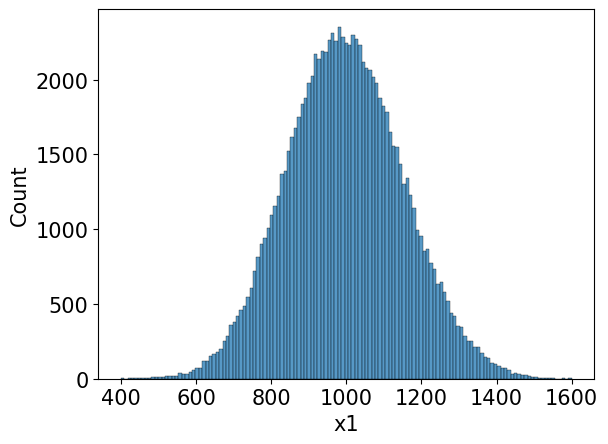

In [15]:
fig,ax=plt.subplots()
sns.histplot(data=df, x='x1')

In [ ]:

fig,ax=plt.subplots(ncols=3, figsize=(15, 5))

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax[0].axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax[0])
ax[0].set_xlabel(r'$z_t$')

# second plot
sns.histplot(df[df.status!=0], x='x1', hue='status', ax=ax[1])
ax[1].axvline(x=df[df.status==0].x1.mean(), color='b', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==1].x1.mean(), color='y', alpha=.5, linestyle='-.')
ax[1].axvline(x=df[df.status==2].x1.mean(), color='g', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==3].x1.mean(), color='r', alpha=.5, linestyle='--')
ax[1].set_xlabel(r'$x_t^{(1)}$ (SAT score)')

# third plot
sns.histplot(df[df.status!=0], x='x2', hue='status', ax=ax[2])
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df.status==env_idx].x2.mean())
  ax[2].axvline(x=df[df.status==env_idx].x2.mean(), c=c, linestyle='--')

# ax[2].axvline(x=df[df.status==3].x2.mean(), c='r', linestyle='-.', alpha=.5)
ax[2].set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 

In [160]:
# # theta changing. 
# cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 3 --theta-star-std .1 --envs-accept-rates .2 .6 1'
# args = script.get_args(cmd)
# np.random.seed(1)
# b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    # args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    # )

## protocol vs. no protocol

In [2]:
_runs = []
for nce  in tqdm.tqdm((2, 1)):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 50  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

299it [02:22,  2.09it/s]
299it [02:21,  2.11it/s]
299it [02:23,  2.09it/s]
299it [02:22,  2.09it/s]
299it [02:22,  2.10it/s]
299it [02:23,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.07it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:26,  2.04it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.06it/s]
299it [02:26,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:26,  2.03it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.04it/s]
299it [02:27,  2.03it/s]
299it [02:26,  2.05it/s]
299it [02:27,  2.03it/s]
299it [02:27,  2.03it/s]
299it [02:27,  2.03it/s]
299it [02:27,  2.03it/s]
299it [02:26,  2.04it/s]
299it [02:27,  2.03it/s]


In [3]:
runs0 = [r[0] for r in _runs[0]]
runs1 = [r[0] for r in _runs[1]]
df0 = script.runs2df(runs0)
df1 = script.runs2df(runs1)
df0['protocol'] = True
df1['protocol'] = False
df = pd.concat((df0,df1))
df
dflong = pd.melt(df, id_vars=('iterations', 'protocol'), value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error' )
dflong['env']=dflong.env.astype('category').cat.rename_categories({'ours_env0':'1', 'ours_env1': '2'})
dflong 
dflong['cooperative envs.'] = dflong['protocol'].apply(lambda x: 2 if x else 1)
dflong['cooperative envs.'] = dflong['cooperative envs.'].astype('category')
# dflong = dflong.rename(columns={'env': '_env'})
dflong 

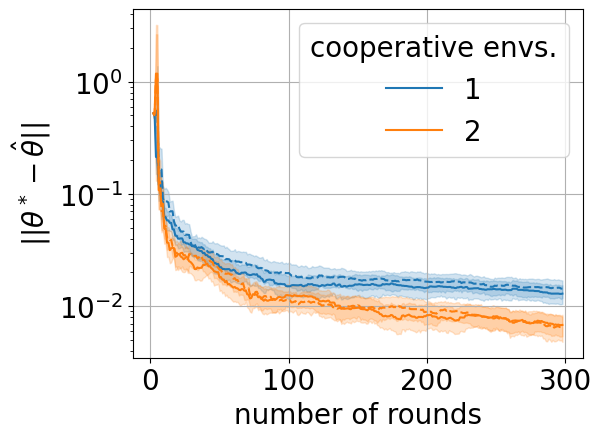

In [9]:
fig,ax=plt.subplots()

sns.lineplot(data=dflong, x='iterations', y='error', style='env',  hue='cooperative envs.', ax=ax)
ax.grid()

# customize the legend
(handles, labels) = ax.get_legend_handles_labels() 
L = ax.legend(handles[1:3], labels[1:3], title='cooperative envs.') 

# x/y labels.
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_yscale('log')
plt.tight_layout() 
plt.savefig('figures/protocol-vs-no-protocol.pdf')

In [63]:
L.set

In [38]:
save_runs('experiments', 'protocol-vs-no-protocol', dflong, args)

In [81]:
# number of cooperative envs. experiments.
_runs = []
n_envs = 3
coop_envs = (3,2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = f'--num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

99it [00:30,  3.23it/s]
99it [00:31,  3.16it/s]
99it [00:30,  3.25it/s]
99it [00:31,  3.15it/s]
99it [00:31,  3.14it/s]
99it [00:31,  3.12it/s]
99it [00:31,  3.17it/s]
99it [00:31,  3.12it/s]
99it [00:31,  3.12it/s]
99it [00:32,  3.08it/s]
99it [00:32,  3.09it/s]
99it [00:32,  3.08it/s]
99it [00:31,  3.16it/s]
99it [00:31,  3.13it/s]
99it [00:29,  3.30it/s]
99it [00:30,  3.26it/s]
99it [00:31,  3.10it/s]
99it [00:31,  3.13it/s]
99it [00:32,  3.03it/s]
99it [00:32,  3.05it/s]
99it [00:31,  3.09it/s]
99it [00:33,  3.00it/s]
99it [00:31,  3.14it/s]
99it [00:31,  3.19it/s]
99it [00:30,  3.27it/s]
99it [00:31,  3.11it/s]
99it [00:33,  2.99it/s]
99it [00:32,  3.02it/s]
99it [00:32,  3.06it/s]
99it [00:32,  3.05it/s]
99it [00:31,  3.14it/s]
99it [00:31,  3.11it/s]
99it [00:32,  3.06it/s]
99it [00:33,  2.99it/s]
99it [00:32,  3.01it/s]
99it [00:31,  3.12it/s]
99it [00:30,  3.26it/s]
99it [00:32,  3.06it/s]
99it [00:30,  3.22it/s]
99it [00:31,  3.19it/s]
99it [00:31,  3.13it/s]
99it [00:30,  3.

In [114]:
runs0 = [r[0] for r in _runs[0]]
runs1 = [r[0] for r in _runs[1]]
# runs2 = [r[0] for r in _runs[2]]
df0 = script.runs2df(runs0)
df1 = script.runs2df(runs1)
# df2 = script.runs2df(runs2)
df0['protocol'] = True
df1['protocol'] = False
df = pd.concat((df0,df1))
df


,iterations,ours_env0,ours_env1,ours_env2,protocol
0,0,NaN,NaN,NaN,True
1,1,NaN,NaN,NaN,True
2,2,0.676385,0.540016,0.597875,True
3,3,0.676385,0.540016,0.597875,True
4,4,0.024575,0.342013,0.114422,True
...,...,...,...,...,...
9895,94,0.004917,0.018749,0.007543,False
9896,95,0.004917,0.018749,0.007543,False
9897,96,0.004411,0.019335,0.007543,False
9898,97,0.004411,0.019335,0.006353,False


In [116]:
df['ours_env0-1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df

,iterations,ours_env0,ours_env1,ours_env2,protocol,ours_env0-1
0,0,NaN,NaN,NaN,True,NaN
1,1,NaN,NaN,NaN,True,NaN
2,2,0.676385,0.540016,0.597875,True,0.608200
3,3,0.676385,0.540016,0.597875,True,0.608200
4,4,0.024575,0.342013,0.114422,True,0.183294
...,...,...,...,...,...,...
9895,94,0.004917,0.018749,0.007543,False,0.011833
9896,95,0.004917,0.018749,0.007543,False,0.011833
9897,96,0.004411,0.019335,0.007543,False,0.011873
9898,97,0.004411,0.019335,0.006353,False,0.011873


In [118]:
dflong = pd.melt(df, id_vars=('iterations', 'protocol'), value_vars=('ours_env0-1', 'ours_env2'), var_name='env', value_name='error' )
dflong['env']=dflong.env.astype('category').cat.rename_categories({'ours_env0-1':'avg(1,2)', 'ours_env2': '3'})
dflong['cooperative envs.'] = dflong['protocol'].apply(lambda x: 3 if x else 2)
dflong['cooperative envs.'] = dflong['cooperative envs.'].astype('category')
# dflong = dflong.rename(columns={'env': '_env'})
dflong 

,iterations,protocol,env,error,cooperative envs.
0,0,True,"avg(1,2)",NaN,3
1,1,True,"avg(1,2)",NaN,3
2,2,True,"avg(1,2)",0.608200,3
3,3,True,"avg(1,2)",0.608200,3
4,4,True,"avg(1,2)",0.183294,3
...,...,...,...,...,...
39595,94,False,3,0.007543,2
39596,95,False,3,0.007543,2
39597,96,False,3,0.007543,2
39598,97,False,3,0.006353,2


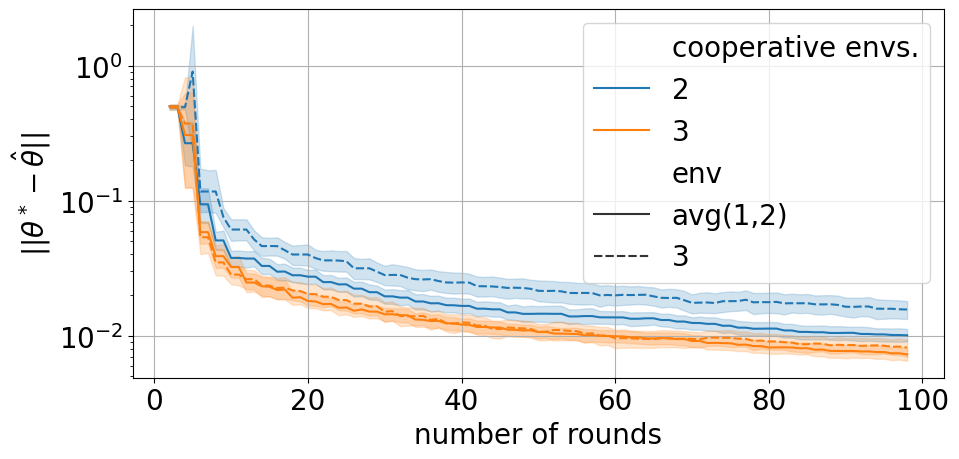

In [119]:
fig,ax=plt.subplots(figsize=(10, 5))

sns.lineplot(data=dflong, x='iterations', y='error', style='env',  hue='cooperative envs.', ax=ax)
ax.grid()

# customize the legend
# (handles, labels) = ax.get_legend_handles_labels() 
# L = ax.legend(handles[1:3], labels[1:3], title='cooperative envs.') 
ax.legend(bbox_to_anchor=(1,1))

# x/y labels.
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_yscale('log')
plt.tight_layout() 
plt.savefig('figures/protocol-vs-no-protocol.pdf')

In [120]:
## over 5 environments.
_runs = []
n_envs = 3
coop_envs = (3, 2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = f'--offline-eval --num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:00,  1.18it/s]
1it [00:01,  1.13s/it]
1it [00:01,  1.09s/it]
1it [00:01,  1.89s/it]
1it [00:01,  1.80s/it]
1it [00:01,  1.41s/it]
1it [00:01,  1.93s/it]
1it [00:01,  1.44s/it]
1it [00:01,  1.97s/it]
1it [00:01,  1.98s/it]
1it [00:01,  1.49s/it]
1it [00:01,  1.20s/it]
1it [00:01,  1.30s/it]
1it [00:01,  1.44s/it]
1it [00:01,  1.05s/it]
1it [00:01,  1.30s/it]
1it [00:01,  1.97s/it]
1it [00:02,  2.18s/it]
1it [00:02,  2.55s/it]
1it [00:02,  2.23s/it]
1it [00:02,  2.36s/it]
1it [00:01,  1.89s/it]
1it [00:02,  2.20s/it]
1it [00:01,  1.97s/it]
1it [00:02,  2.24s/it]
1it [00:02,  2.14s/it]
1it [00:01,  1.79s/it]
1it [00:01,  1.89s/it]
1it [00:01,  1.98s/it]
1it [00:02,  2.42s/it]
1it [00:01,  1.79s/it]
1it [00:01,  1.65s/it]
1it [00:02,  2.25s/it]
1it [00:02,  2.30s/it]
1it [00:02,  2.01s/it]
1it [00:01,  1.26s/it]
1it [00:01,  1.66s/it]
1it [00:01,  1.62s/it]
1it [00:01,  1.40s/it]
1it [00:01,  1.48s/it]
1it [00:01,  1.61s/it]
1it [00:01,  1.38s/it]
1it [00:01,  1.51s/it]
1it [00:01,

In [141]:
dfs = []
for i, nce in enumerate((coop_envs)):
  df = script.runs2df([r[0] for r in _runs[i]])
  df['cooperative envs.'] = r'$\{e_1, e_2, e_3\}$' if nce == 3 else r'$\{e_1, e_2\}$'
  dfs.append(df)
# # runs2 = [r[0] for r in _runs[2]]
# df0 = script.runs2df(runs0)
# runs1 = [r[0] for r in _runs[1]]
# df1 = script.runs2df(runs1)
# # df2 = script.runs2df(runs2)
# df0['protocol'] = True
# df1['protocol'] = False
# df = pd.concat((df0,df1))
# df
df = pd.concat(dfs)
df 
df['ours_env0+ours_env1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df 

,iterations,ours_env0,ours_env1,ours_env2,cooperative envs.,ours_env0+ours_env1
0,0,0.000216,0.008405,0.002526,"$\{e_1, e_2, e_3\}$",0.004310
1,0,0.007288,0.006607,0.008001,"$\{e_1, e_2, e_3\}$",0.006947
2,0,0.016030,0.001949,0.007235,"$\{e_1, e_2, e_3\}$",0.008990
3,0,0.004616,0.013297,0.011648,"$\{e_1, e_2, e_3\}$",0.008956
4,0,0.002084,0.009452,0.000084,"$\{e_1, e_2, e_3\}$",0.005768
...,...,...,...,...,...,...
95,0,0.001422,0.010799,0.002617,"$\{e_1, e_2\}$",0.006110
96,0,0.004984,0.012756,0.021000,"$\{e_1, e_2\}$",0.008870
97,0,0.006299,0.002638,0.009857,"$\{e_1, e_2\}$",0.004468
98,0,0.009096,0.010065,0.011538,"$\{e_1, e_2\}$",0.009581


In [142]:
# value_vars= (f'ours_env{i}' for i in range(n_envs))
value_vars=('ours_env0+ours_env1', 'ours_env2')
# rename_categories_arg = {f'ours_env{i}': f'{i+1}' for i in range(n_envs)}
dflong = pd.melt(df, id_vars=('iterations', 'cooperative envs.'), value_vars=value_vars, var_name='env', value_name='error' )
dflong 

dflong['env']=dflong.env.astype('category').cat.rename_categories({'ours_env0+ours_env1': r'avg($e_1, e_2$)', 'ours_env2': r'$e_3$'})
# dflong['cooperative envs.'] = dflong['protocol'].apply(lambda x: 3 if x else 2)
# dflong['cooperative envs.'] = dflong['cooperative envs.'].astype('category')
# dflong = dflong.rename(columns={'env': '_env'})
dflong 

,iterations,cooperative envs.,env,error
0,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.004310
1,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.006947
2,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.008990
3,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.008956
4,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.005768
...,...,...,...,...
395,0,"$\{e_1, e_2\}$",$e_3$,0.002617
396,0,"$\{e_1, e_2\}$",$e_3$,0.021000
397,0,"$\{e_1, e_2\}$",$e_3$,0.009857
398,0,"$\{e_1, e_2\}$",$e_3$,0.011538


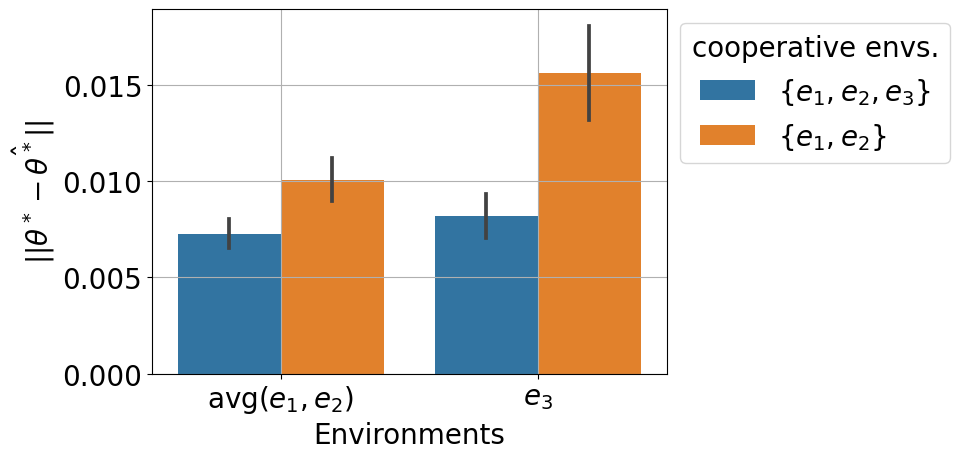

In [143]:
fig,ax=plt.subplots(figsize=(10, 5 ))
sns.barplot(dflong, x='env', hue='cooperative envs.', y='error')
ax.legend(bbox_to_anchor=(1,1), title='cooperative envs.')
ax.grid() 
ax.set_ylabel(r'$|| \theta^* - \hat{\theta^*}||$')
ax.set_xlabel('Environments')

plt.tight_layout()
plt.savefig('figures/experiment-appendix.pdf')

## utility stuff (for single env.)

In [7]:
# first estimating causal parameters using data generated according to cooperative protocol.
from sklearn.linear_model import LinearRegression
cmd = '--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .25'
args = script.get_args(cmd)
# err_list, _, _, est_list = script.run_multi_env(seed=1, args=args)
seed = 1
np.random.seed(seed)
_, x, y, EET, theta, w, z, _, _, _, _, theta_star, pref_vect  = script.generate_data(
args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
)

err_list, est_list = {}, {}
envs_itr = range(args.num_envs)
for env_idx in envs_itr:
    dictenv_err, dictenv_est = script.run_single_env(args, x, y, theta, z, theta_star, env_idx, pref_vect, EET, None, None, None)
    for k, v in dictenv_err.items():
        err_list[f'{k}_env{env_idx}'] = v
    for k, v in dictenv_est.items():
        est_list[f'{k}_env{env_idx}'] = v

99it [00:05, 16.76it/s] 


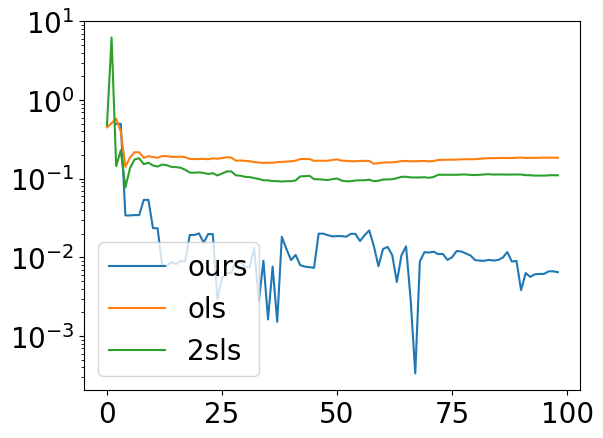

In [8]:
fig,ax=plt.subplots()
plt.plot(err_list['ours_env0'], label='ours')
plt.plot(err_list['ols_env0'], label='ols')
plt.plot(err_list['2sls_env0'], label='2sls')
ax.legend( )
ax.set_yscale('log')

In [26]:
# a function to return the utility.
def get_utility(A, B, EET, theta_star, theta):
  assert A.ndim == 1
  assert theta.shape == A.shape
  assert theta_star.ndim== 1 
  assert theta.ndim== 1 
  
  return A.dot(theta) + B + theta.dot(EET.dot(theta_star))

# dataset for utility maximization
assert args.num_envs == 1, f"so far only implemented for a single environment"
env_idx = 0
# extracting unique thetas i.e one per each round.
theta_rounds_env = theta[env_idx, 0::args.applicants_per_round] # (n_rounds, 2) 
assert theta_rounds_env.ndim == 2
n_rounds = theta_rounds_env.shape[0]

A = np.array([3,4])
B = 2 
seed = 1
np.random.seed(seed)
y_utility = np.ones(shape=(n_rounds, args.applicants_per_round)) * np.nan
impr_arr = np.zeros(shape=(n_rounds,))

for i, th in enumerate(theta_rounds_env):
    # number of accepted students at uni, same as in cooperative protocol.
    n_samples = (z[i*args.applicants_per_round: (i*args.applicants_per_round) + args.applicants_per_round] == env_idx+1).sum ()  # equals to 500. 
    base = A.dot(th) + B + np.random.normal(loc=0, scale=args.utility_dataset_std, size=(n_samples,))
    impr = th.dot((EET).dot(theta_star[env_idx]))
    
    impr_arr[i] = impr
    
    y_utility[i, :n_samples] = base + impr


In [27]:
# estimate A and theta_AO
def infer_theta_ao(theta_rounds_env, n_rounds, A, B, y_utility, theta_star_est):
    cpi, cbp = np.zeros((n_rounds, )), np.zeros((n_rounds, ))
    for i, theta_round in enumerate(theta_rounds_env):
        cpi[i] = theta_round.dot(EET.dot(theta_star_est))
        cbp[i] = np.nanmean(y_utility[i]) - cpi[i]

    # assert np.all(impr_arr==cpi) 
    from sklearn.linear_model import LinearRegression

    A_est = np.zeros((n_rounds, 2 ))
    A_est_err = np.zeros((n_rounds, ))
    thetas_ao = np.zeros((n_rounds, 2))
    utilities = np.zeros((n_rounds, ))

    for r in range(1, n_rounds):
      m = LinearRegression()
      m.fit(theta_rounds_env[:r], cbp[:r])
  
      A_est[r] = m.coef_ 
      thetas_ao[r] = A_est[r] + EET.dot(theta_star_est)
      thetas_ao[r] = thetas_ao[r] / np.linalg.norm(thetas_ao[r ])
  
      utilities[r] = get_utility(A, B, EET, theta_star[0], thetas_ao[r])
  
      A_est_err[r] = np.linalg.norm(A_est[r] - A)
    
    return utilities, thetas_ao, A_est, A_est_err

utilities_our, thetas_ao_our, _, A_est_err_our = infer_theta_ao(theta_rounds_env, n_rounds, A, B, y_utility, est_list['ours_env0'][-1]) 

Text(0, 0.5, 'utility')

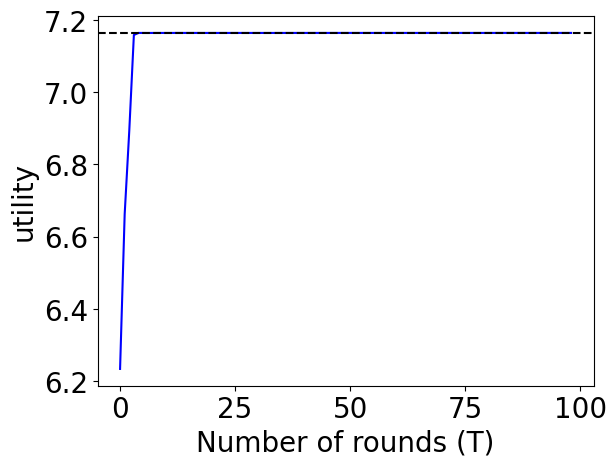

In [28]:
# plt.plot(utilities_our[1:])
fig,ax=plt.subplots()
ax.plot(utilities_our[1:], color='b', label='our')

# plot the ground truth theta_ao
theta_ao = A + EET.dot(theta_star[0])
theta_ao = theta_ao / np.linalg.norm(theta_ao)

max_utility =get_utility(A, B, EET, theta_star[0], theta_ao)
max_utility

ax.axhline(y=max_utility, linestyle='--', color='k')
ax.set_xlabel('Number of rounds (T)')
ax.set_ylabel('utility')


4.410374273709158

In [16]:
B

1.99